# Question 5

In [12]:
import pandas as pd
import numpy as np
!pip install arch --upgrade
from arch import arch_model
from scipy.stats import norm
from scipy.stats import t
import scipy.stats as stats
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
kospi = pd.read_csv("^kospi_d.csv", parse_dates=["Date"], index_col="Date")
ndx = pd.read_csv("^ndx_d.csv")
# kospi is longer

In [3]:
kospi = kospi.sort_index()

In [4]:
# Resample to get Thursday closing prices (weekly)
thursday_prices = kospi.resample("W-THU").last()

# Select every second Thursday to get non-overlapping 2-week returns
non_overlapping_thursdays = thursday_prices.iloc[::2]

# Compute non-overlapping returns
returns = (non_overlapping_thursdays["Close"] / non_overlapping_thursdays["Close"].shift(1)) - 1
returns = returns.dropna()  # Remove any NaN values that result from the shift

In [5]:
# get first 10 years
start_date = returns.index.min()  # Get the first available date
end_date = start_date + pd.DateOffset(years=10)  # Add 10 years to the start date

# Filter the returns to get the first 10 years
first_10_years_returns = returns[(returns.index >= start_date) & (returns.index < end_date)]

In [6]:
# 5. Fit a GARCH(1,1) model to the initial sample with a constant mean
garch_model = arch_model(first_10_years_returns, vol='Garch', p=1, q=1, mean='Constant')
garch_fit = garch_model.fit()

# 6. Calculate the 5% 2-week VaR using the GARCH model
# Forecast the volatility for the next 2-week period
forecast_horizon = 1  # 1-step ahead forecast for the next 2 weeks (since returns are biweekly)
forecast = garch_fit.forecast(horizon=forecast_horizon)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 928135320.7316562
Iteration:      2,   Func. Count:     17,   Neg. LLF: -391.56286680197184
Iteration:      3,   Func. Count:     26,   Neg. LLF: -315.7419461043495
Iteration:      4,   Func. Count:     33,   Neg. LLF: 661.502245055538
Iteration:      5,   Func. Count:     41,   Neg. LLF: -436.64272537863314
Iteration:      6,   Func. Count:     48,   Neg. LLF: -486.7013756188071
Iteration:      7,   Func. Count:     54,   Neg. LLF: -486.7653087953152
Iteration:      8,   Func. Count:     59,   Neg. LLF: -486.76610981474664
Iteration:      9,   Func. Count:     63,   Neg. LLF: -486.76610981498357
Optimization terminated successfully    (Exit mode 0)
            Current function value: -486.76610981474664
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 9


/usr/local/python/3.12.1/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001478. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
# Extract the volatility forecast for the 2-week horizon
volatility_forecast = forecast.variance.values ** 0.5  # square root for volatility

estimated_mean = garch_fit.params['mu']

# Calculate the 5% VaR for the 2-week horizon using the normal distribution
confidence_level = 0.05

# SHOULD WE ASSUME e is NORMAL?

z_score = norm.ppf(confidence_level)  # Get the z-score for the 5% level
VaR_5_percent_norm = -estimated_mean -z_score * volatility_forecast  # The VaR is negative because it represents a loss

In [8]:
# assume e follows t-dist
params = stats.t.fit(first_10_years_returns)

# Extract the degrees of freedom (df) from the fitted parameters
degrees_of_freedom = params[0]

t_quantile = t.ppf(confidence_level, df=degrees_of_freedom)

VaR_5_percent_t = -estimated_mean - t_quantile * volatility_forecast

In [18]:
# 8. Update model: Rolling window
window_size = len(first_10_years_returns)  # Rolling window size

# Initialize an empty list to store VaR values
var_5_percent_norm_list = []
var_5_percent_t_list = []

# Loop through rolling windows
for i in range(len(returns) - window_size):
    rolling_sample = returns.iloc[i : i + window_size]  # Get the rolling window sample

    # Fit a GARCH(1,1) model to the rolling sample
    garch_model = arch_model(rolling_sample, vol='Garch', p=1, q=1, mean='Constant')
    garch_fit = garch_model.fit(disp="off")  # Suppress output

    # Forecast the volatility for the next 2-week period
    forecast = garch_fit.forecast(horizon=1)
    volatility_forecast = np.sqrt(forecast.variance.values)  # Extract latest forecasted volatility

    # Estimated mean return
    estimated_mean = garch_fit.params['mu']

    # Compute VaR
    VaR_5_p_norm = -estimated_mean - z_score * volatility_forecast  
    VaR_5_p_t = -estimated_mean - t_quantile * volatility_forecast
    var_5_percent_norm_list.append(VaR_5_p_norm)
    var_5_percent_t_list.append(VaR_5_p_t)

# Convert the VaR list to a DataFrame with timestamps
var_norm_series = pd.Series(var_5_percent_norm_list, index=returns.index[window_size:])
var_t_series = pd.Series(var_5_percent_t_list, index=returns.index[window_size:])

/usr/local/python/3.12.1/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001478. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001461. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/arch

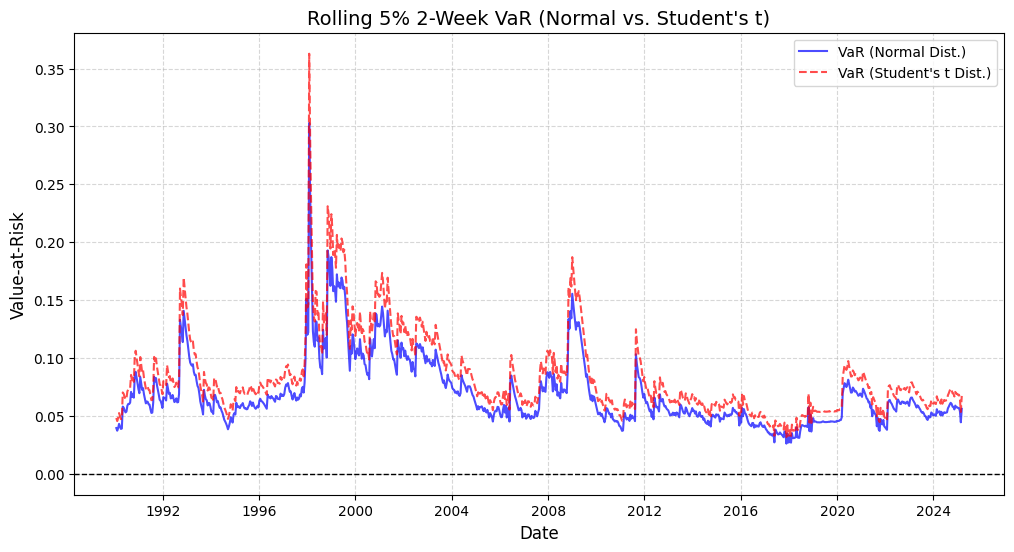

In [13]:
# Plot the two VaR series
plt.figure(figsize=(12, 6))
plt.plot(var_norm_series, label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(var_t_series, label="VaR (Student's t Dist.)", linestyle="--", color="red", alpha=0.7)

# Add titles and labels
plt.title("Rolling 5% 2-Week VaR (Normal vs. Student's t)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk", fontsize=12)
plt.axhline(0, color="black", linewidth=1, linestyle="--")  # Reference line at 0
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()